## Abstractive Text Summarization using Seq2Seq LSTM for CNN Daily Mail Dataset.

In [3]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import nltk
nltk.download('stopwords')  
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nanda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
##Read the dataset

This dataset consists of CNN daily Mails. Download the dataset from kaggle.

https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail

In [ ]:
summary=pd.read_csv("cnn_news_summary.csv",encoding='iso-8859-1')
raw=pd.read_csv("cnn_news_summary_more.csv",encoding='iso-8859-1')

In [ ]:
summary=summary[:1000]

102915

In [ ]:
len(raw)

98401

In [ ]:
pre1 = raw.iloc[:, 0:2].copy()
pre2 = summary.iloc[:, 0:6].copy()

# To increase the intake of possible text values to build a reliable model
pre2['text'] = pre2['author'].str.cat(pre2['date'
        ].str.cat(pre2['read_more'].str.cat(pre2['text'
        ].str.cat(pre2['ctext'], sep=' '), sep=' '), sep=' '), sep=' ')

pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'], pre2['headlines']],
                           ignore_index=True)

### Preprocessing
Data cleaning is an important part of the text summarization. Using unclean data may result into the disastrous results.

In [ ]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):

    for row in column:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

In [ ]:
processed_text = text_strip(pre['text'])
processed_summary = text_strip(pre['summary'])

In [ ]:
import spacy
from time import time

nlp = spacy.load('en', disable=['ner', 'parser']) 

# Process text as batches and yield Doc objects in order
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=5000)]

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=5000)]

Cleaned Data

In [ ]:
data=pd.DataFrame()
data['cleaned_text']=pd.Series(text)
data['cleaned_summary']=pd.Series(summary)

Analyzing the distribution of the sequences.
Look at the length of the CNN daily mails and the summary to get an overall idea about the distribution of length of the text to fix the maximum length of the sequence to be generated.

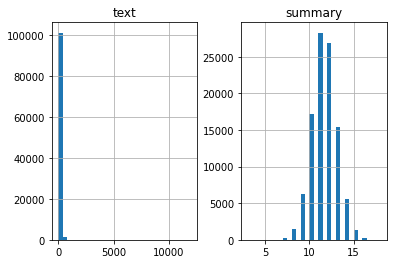

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9578389933440218


In [ ]:
max_text_len=100
max_summary_len=15

In [ ]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
df.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgra...,_START_ upgrad learner switches to career in ml al with 90% salary hike _END_
1,kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users ge...,_START_ delhi techie wins free food from swiggy for one year on cred _END_


add start and end token

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

split data for train and test

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

Preparing the tokenizer, A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.
Mails Tokenizer code is in below cell

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

Rarewords and its Coverage

In [ ]:
thresh=5

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 62.625791318822664
Total Coverage of rare words: 1.6284043690636876


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

29638

Summary Tokenizer

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

Rarewords and its coverage

In [ ]:
thresh=5

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 62.55667945587723
Total Coverage of rare words: 3.018233162064382


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(88513, 88513)

deleting the data with only start and end token

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

### Model
Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

Initial State: This is used to initialize the internal states of the LSTM for the first timestep

Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. 

 Building a 3 stacked LSTM for the encoder:

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     5927600     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
#### Training the Model

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=3,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/3
692/692 [==============================] - 6827s 10s/step - loss: 5.0086 - val_loss: 4.7797
Epoch 2/3
692/692 [==============================] - 6415s 9s/step - loss: 4.6778 - val_loss: 4.4909
Epoch 3/3
692/692 [==============================] - 6377s 9s/step - loss: 4.4184 - val_loss: 4.2606


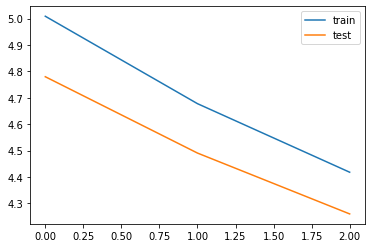

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
target_word_index

{'end': 1,
 'start': 2,
 'sostok': 3,
 'eostok': 4,
 'to': 5,
 'in': 6,
 'for': 7,
 'of': 8,
 'on': 9,
 'india': 10,
 'with': 11,
 'after': 12,
 'at': 13,
 'us': 14,
 'from': 15,
 'over': 16,
 'as': 17,
 'by': 18,
 'the': 19,
 'man': 20,
 'not': 21,
 'be': 22,
 'is': 23,
 'pm': 24,
 'govt': 25,
 'up': 26,
 'old': 27,
 'delhi': 28,
 'indian': 29,
 'trump': 30,
 'world': 31,
 'bjp': 32,
 'crore': 33,
 'was': 34,
 'i': 35,
 'will': 36,
 'cm': 37,
 'modi': 38,
 'report': 39,
 'new': 40,
 'woman': 41,
 'year': 42,
 '1st': 43,
 'who': 44,
 'his': 45,
 'against': 46,
 'first': 47,
 'no': 48,
 'it': 49,
 'and': 50,
 'ex': 51,
 'my': 52,
 '000': 53,
 'can': 54,
 'day': 55,
 'out': 56,
 'have': 57,
 'time': 58,
 'mumbai': 59,
 'pak': 60,
 'film': 61,
 'reports': 62,
 'china': 63,
 'years': 64,
 'people': 65,
 'yr': 66,
 'police': 67,
 'sc': 68,
 'case': 69,
 'lakh': 70,
 'ceo': 71,
 'women': 72,
 'me': 73,
 'get': 74,
 'gets': 75,
 'startup': 76,
 'killed': 77,
 'video': 78,
 'minister': 79,
 'r

## Inference
After training, the model is tested on new source sequences for which the target sequence is unknown. So, we set up the inference architecture to decode a test sequence.

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
Below are the functions to convert an integer sequence to a word sequence for summary as well as the reviews

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '
    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

### Printing few summaries

In [ ]:
for i in range(0, 50):
    
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print ('\n')

Review: lok janshakti party president ram vilas paswan daughter asha has said she will contest elections against him from constituency if given ticket from lalu prasad yadav rjd she accused him of neglecting her and promoting his son chirag asha is paswan daughter from his first wife while chirag is his son from his second wife 
Original summary: start will contest against father ram vilas from daughter end 
Predicted summary:  start i am the first time in india cricket end


Review: irish deputy prime minister frances fitzgerald announced her resignation on tuesday in bid to avoid the collapse of the government and potential snap election she quit hours before no confidence motion was to be proposed against her by the main opposition party the political crisis began over fitzgerald role in police whistleblower scandal 
Original summary: start irish deputy prime minister resigns to avoid govt collapse end 
Predicted summary:  start india to be in india india pm modi end


Review: rr wi

In [1]:
def calc_rouge_scores(pred_summaries, gold_summaries, 
                                 keys=['rouge1', 'rougeL'], use_stemmer=True):
    #Calculate rouge scores
    scorer = rouge_scorer.RougeScorer(keys, use_stemmer= use_stemmer)
    
    n = len(pred_summaries)
    
    scores = [scorer.score(pred_summaries[j], gold_summaries[j]) for 
              j in range(n)] 
    
    dict_scores={}                                                            
    for key in keys:
        dict_scores.update({key: {}})
        
    
    for key in keys:
        
        precision_list = [scores[j][key][0] for j in range(len(scores))]
        recall_list = [scores[j][key][1] for j in range(len(scores))]
        f1_list = [scores[j][key][2] for j in range(len(scores))]

        precision = np.mean(precision_list)
        recall = np.mean(recall_list)
        f1 = np.mean(f1_list)
        
        dict_results = {'recall': recall, 'precision': precision, 'f1': f1}
        
        dict_scores[key] = dict_results
        
    return dict_scores

In [6]:
from rouge_score import rouge_scorer

In [4]:
predicted_cnn_lstm_df=pd.read_csv('predicted_cnn_1.csv')
original_cnn_lstm_df=pd.read_csv('original_cnn_1.csv')

In [5]:
predicted_summary_cnn_lstm=[]
original_summary_cnn_lstm=[]
for i in range(predicted_cnn_lstm_df.shape[0]):
    predicted_summary_cnn_lstm.append(predicted_cnn_lstm_df['predicted_summary'][i])
    original_summary_cnn_lstm.append(original_cnn_lstm_df['original_summary'][i])

### Rouge Evaluation 

In [7]:
dict_scores_cnn_lstm=calc_rouge_scores(predicted_summary_cnn_lstm,original_summary_cnn_lstm)

In [8]:
dict_scores_cnn_lstm

{'rouge1': {'recall': 0.09221428571428572,
  'precision': 0.0773109668109668,
  'f1': 0.019537258871159799},
 'rougeL': {'recall': 0.09221428571428572,
  'precision': 0.0773109668109668,
  'f1': 0.19537258871159799}}

We have trained the model for 3 epocs and 80000 rows due to the limitation of the GPU cluster as the dataset is large, if we try to train the model for 10 epocs and full dataset then it times out at 6th epoc. If we train the model for more nubmer of epoc and full dataset with more powerful GPU then we will achieve better rouge score. 